# DOE 本番解析用 (base) v3

### プロジェクトのルートのパスを通す

In [16]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリを一括インポート

In [17]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.tse import get_ticker_name_list

### Matplotlib のフォント設定（オプション）

In [18]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

### 収益用等高線図のプロット（コア部分のみ）

In [19]:
def plot_contourmap(ax, Xi, Yi, Zi):
    # z>0 の等高線（暖色）
    levels_pos = np.linspace(0, np.nanmax(Zi), 8)
    cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)
    # z<0 の等高線（寒色）
    levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
    cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)
    # z=0 の等高線（黒）
    cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)

    # ラベル
    ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")
    ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")
    ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

### ファイル名から日付を返す関数

In [20]:
# ファイル名から日付を返す関数
def get_date_from_file(file: str) -> pd.Timestamp:
    pattern = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
    if m := pattern.match(file):
        return pd.to_datetime(f"{m.group(1)}-{m.group(2)}-{m.group(3)}")
    else:
        return pd.to_datetime("1970-01-01")

### データフレーム ⇒ HTML 出力用文字列を返す関数

In [21]:
def conv_df2html(df: pd.DataFrame):
    # HTML 形式で出力
    styled = df.style.format({"取引回数": "{:d}", "損益": "{:.1f}"}).set_table_styles(
        [
            {"selector": "td", "props": "text-align: right;"},
        ]
    )
    html = styled.to_html()
    return html

## CSV ファイル一覧の取得

In [22]:
name_doe = "doe-8"  # 実験計画名（フォルダ名）
#name_code = "7011"  # 銘柄コード
name_code = "7203"  # 銘柄コード
# name_code = "8306"  # 銘柄コード
dict_code = get_ticker_name_list([name_code])

# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file = sorted(os.listdir(path_dir))

print("\n分析対象のシミュレーション・ファイル")
print(list_file)

n_day = len(list_file)
print(f"# of tick files : {n_day}")

# 最後のファイル名から日付文字列を取得して出力するファイル名に付与するための日付文字列を生成
file_last = list_file[-1]
pattern_date = re.compile(r".+_(\d{8})\..+")
if m := pattern_date.match(file_last):
    date_str = m.group(1)  # 保存ファイル目に付与する日付
else:
    date_str = "00000000"
print(f"\n日付文字列 : {date_str}")


分析対象のシミュレーション・ファイル
['ticks_20250819.csv', 'ticks_20250820.csv', 'ticks_20250821.csv', 'ticks_20250822.csv', 'ticks_20250825.csv', 'ticks_20250826.csv', 'ticks_20250827.csv', 'ticks_20250828.csv', 'ticks_20250829.csv', 'ticks_20250901.csv', 'ticks_20250902.csv', 'ticks_20250903.csv', 'ticks_20250904.csv', 'ticks_20250905.csv', 'ticks_20250908.csv', 'ticks_20250909.csv', 'ticks_20250910.csv', 'ticks_20250911.csv', 'ticks_20250912.csv', 'ticks_20250916.csv', 'ticks_20250917.csv', 'ticks_20250918.csv', 'ticks_20250919.csv', 'ticks_20250922.csv', 'ticks_20250924.csv', 'ticks_20250925.csv', 'ticks_20250926.csv', 'ticks_20250929.csv', 'ticks_20250930.csv', 'ticks_20251001.csv', 'ticks_20251002.csv', 'ticks_20251003.csv', 'ticks_20251006.csv', 'ticks_20251007.csv', 'ticks_20251008.csv', 'ticks_20251009.csv', 'ticks_20251010.csv', 'ticks_20251014.csv', 'ticks_20251015.csv', 'ticks_20251016.csv', 'ticks_20251017.csv', 'ticks_20251020.csv', 'ticks_20251021.csv', 'ticks_20251022.csv', 'ticks_2025

## CSV ファイルの読み込み

In [23]:
list_df = list()
for i, file in enumerate(list_file):
    path_csv = os.path.join(path_dir, file)
    df_tick = pd.read_csv(path_csv)
    list_df.append(df_tick)

## 本日の DOE 結果

In [24]:
# 本日の DOE データ
list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "trade", "total"]
list_col_new = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "損益"]

df_latest = list_df[-1][list_col].copy()
df_latest.columns = list_col_new
df_latest["備考"] = ""
dt_last = get_date_from_file(list_file[-1])
print(f"\n{dt_last.date()} のシミュレーション結果")
print(df_latest)

html = conv_df2html(df_latest)
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_latest_single.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 本日のベスト条件
total_max = df_latest["損益"].max()
df_latest_max = df_latest[df_latest["損益"] == total_max][list_col_new].copy()
df_latest_max.columns = list_col_new
print(f"\n{dt_last.date()} のベスト条件")
print(df_latest_max)


2025-12-26 のシミュレーション結果
     PERIOD_MA_1  PERIOD_MA_2  取引回数   損益 備考
0             30          300     2  3.0   
1             40          300     4  0.0   
2             50          300     2  5.0   
3             60          300     2  3.0   
4             70          300     2  4.0   
..           ...          ...   ...  ... ..
284          150         1100     0  0.0   
285          160         1100     0  0.0   
286          170         1100     0  0.0   
287          180         1100     0  0.0   
288          190         1100     0  0.0   

[289 rows x 5 columns]

2025-12-26 のベスト条件
    PERIOD_MA_1  PERIOD_MA_2  取引回数   損益
94          120          550     2  6.0
95          130          550     2  6.0
97          150          550     2  6.0


## 本日の条件

In [25]:
x_por = 60
y_por = 600
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
print(df_latest[(df_latest[col_x] == x_por) & (df_latest[col_y] == y_por)])

     PERIOD_MA_1  PERIOD_MA_2  取引回数   損益 備考
105           60          600     0  0.0   


## データフレームの連結（ヒストリカルデータ解析用）

In [26]:
df = pd.concat(list_df)
list_df.clear()  # 連結前のデータフレームリストを削除

df.reset_index(inplace=True, drop=True)
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_doe_results.csv",
)
df.to_csv(output, index=False)
print("\n日毎のシミュレーション結果を連結したデータフレーム")
print(df)


日毎のシミュレーション結果を連結したデータフレーム
                      file  code  trade  total  PERIOD_MA_1  PERIOD_MA_2
0      ticks_20250819.xlsx  7203      6    3.5           30          300
1      ticks_20250819.xlsx  7203      8   31.5           40          300
2      ticks_20250819.xlsx  7203      2   -2.0           50          300
3      ticks_20250819.xlsx  7203      2    1.5           60          300
4      ticks_20250819.xlsx  7203      2    0.0           70          300
...                    ...   ...    ...    ...          ...          ...
25716  ticks_20251226.xlsx  7203      0    0.0          150         1100
25717  ticks_20251226.xlsx  7203      0    0.0          160         1100
25718  ticks_20251226.xlsx  7203      0    0.0          170         1100
25719  ticks_20251226.xlsx  7203      0    0.0          180         1100
25720  ticks_20251226.xlsx  7203      0    0.0          190         1100

[25721 rows x 6 columns]


## 等高線図（本日のデータ）

In [27]:
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "損益"
x = df_latest[col_x]
y = df_latest[col_y]
z = df_latest[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# 等高線図用追加ポイントの修飾
param_best = {
    "marker": "o",
    "facecolor": "limegreen",
    "edgecolor": "darkgreen",
    "s": 40,
    "zorder": 1,
}
param_por = {
    "marker": "*",
    "facecolor": "#f8f",
    "edgecolor": "#606",
    "s": 80,
    "zorder": 1,
}
# 当日分のプロットヘッダー
title_scope = f"{dict_code[name_code]} ({name_code}) on {dt_last.date()}, {len(df_latest)} conditions"
output = os.path.join(
    "..", "output", name_doe, f"{date_str}_{name_code}_contour_single.png"
)

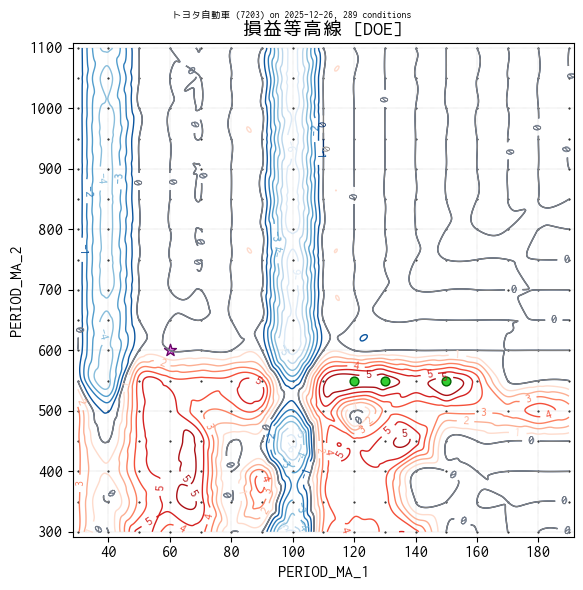

In [28]:
# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# 等高線図
plot_contourmap(ax, Xi, Yi, Zi)

# 本日の条件とベスト条件の点を追加
ax.scatter(df_latest_max[col_x], df_latest_max[col_y], **param_best)
ax.scatter(x_por, y_por, **param_por)
# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title(f"損益等高線 [DOE]")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

plt.tight_layout()
plt.suptitle(title_scope, fontsize=7)
plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 損益分布（本日のデータ）

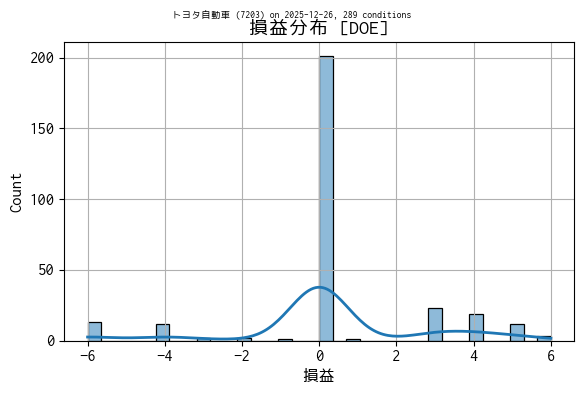

In [29]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(data=df_latest, x="損益", kde=True, line_kws={"linewidth": 2}, ax=ax)
ax.grid()
ax.set_title("損益分布 [DOE]")

plt.tight_layout()
output = os.path.join(
    "..", "output", name_doe, f"{date_str}_{name_code}_hist_single.png"
)
plt.suptitle(title_scope, fontsize=7)
plt.subplots_adjust(top=0.9)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

# ヒストリカル解析

## 最大・最小収益（ヒストリカル）

In [30]:
total_max = df["total"].max()
total_min = df["total"].min()
print("最高収益")
print(df[df["total"] == total_max])
print("\n最低収益")
print(df[df["total"] == total_min])

最高収益
                      file  code  trade  total  PERIOD_MA_1  PERIOD_MA_2
12618  ticks_20251022.xlsx  7203      6   89.0           70          850

最低収益
                      file  code  trade  total  PERIOD_MA_1  PERIOD_MA_2
15195  ticks_20251105.xlsx  7203     15 -119.0          170          750


## サマリ統計の算出（平均）

In [31]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["trade", "total"]

# 因子ごとに応答の平均を集計（サマリデータ）
df_summary = df.groupby(factor_cols)[response_cols].mean().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary = df_summary.sort_values(["PERIOD_MA_2", "PERIOD_MA_1"], ignore_index=True)
print("サマリ統計（平均）")
print(df_summary)

# HTML 形式で出力
styled = df_summary.style.format(
    {"trade": "{:.1f}", "total": "{:.2f}"}
).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)
html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_summary.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

サマリ統計（平均）
     PERIOD_MA_1  PERIOD_MA_2     trade     total
0             30          300  5.730337  0.707865
1             40          300  5.011236 -0.095506
2             50          300  4.044944  1.286517
3             60          300  4.887640  1.943820
4             70          300  4.842697 -0.101124
..           ...          ...       ...       ...
284          150         1100  1.797753  1.584270
285          160         1100  1.617978  0.500000
286          170         1100  1.752809  0.528090
287          180         1100  1.550562 -0.387640
288          190         1100  1.707865  0.393258

[289 rows x 4 columns]


## 日付 × 条件 で収益を集計（平均）

In [32]:
target = "total"
list_ser = list()

# 行 - 日付、列 - 実験条件 で収益を整理
for i, file in enumerate(list_file):
    date_str_idx = get_date_from_file(file)
    ser = pd.read_csv(os.path.join(path_dir, file))[target]
    # pd.Series の name に日付を設定
    ser.name = date_str_idx
    list_ser.append(ser)
# pd.Series を結合して転置
df_raw = pd.concat(list_ser, axis=1).T
print("\ndf_raw: 日付 x 条件で収益")
print(df_raw)


df_raw: 日付 x 条件で収益
             0     1     2     3     4     5     6     7     8     9    ...  \
2025-08-19   3.5  31.5  -2.0   1.5   0.0  -3.5 -15.0 -13.5 -23.0 -21.5  ...   
2025-08-20  10.0  14.5  12.5  14.0  17.0  -0.5   7.0  12.0  10.5  11.0  ...   
2025-08-21   0.0  -2.0  -2.0 -18.5 -16.5 -12.5 -13.5 -15.5  -8.0 -10.5  ...   
2025-08-22   0.5   1.5  -1.0   7.5  11.0  -8.5   0.0   0.5   0.0   0.0  ...   
2025-08-25   8.0  10.0  49.5  39.5  43.5   8.0  37.5   5.5  42.0  47.0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2025-12-22  20.0  15.0  -6.0  10.0   3.0  21.0   6.0  37.0  29.0  26.0  ...   
2025-12-23 -20.0 -16.0 -14.0  -2.0  -1.0   3.0  -2.0  -8.0 -16.0 -21.0  ...   
2025-12-24   2.0   0.0   0.0  -3.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2025-12-25   0.0   0.0   0.0  -4.0  -3.0   1.0   0.0   2.0   2.0  -1.0  ...   
2025-12-26   3.0   0.0   5.0   3.0   4.0   0.0   0.0  -6.0   3.0   3.0  ...   

             279   280   281   

## （ヒストリカル）平均損益の算出

In [33]:
df_mean = df_raw.copy()
# データスコープを示す文字列
dt_start = df_mean.index[0]
dt_end = df_mean.index[-1]
title_scope = f"{dict_code[name_code]} ({name_code}) from {dt_start.date()} to {dt_end.date()}, n = {n_day} days"
print("データスコープを示す文字列")
print(title_scope)

# 平均収益の算出
n = len(df_mean.index)
while n > 0:
    # 最下行から順に平均値を算出して、行の内容を置換。
    df_mean.iloc[n - 1] = df_mean[:n].mean()
    n -= 1
print("\ndf_mean: 新しい日付から古い日付と逆順に平均損益を算出")
print(df_mean)

# 最終日の平均収益のランキング
ser_ranking = df_mean.iloc[len(df_mean) - 1].sort_values(ascending=False)
print("最新の平均損益（逆ソート後）")
print(ser_ranking)

データスコープを示す文字列
トヨタ自動車 (7203) from 2025-08-19 to 2025-12-26, n = 89 days

df_mean: 新しい日付から古い日付と逆順に平均損益を算出
                 0          1          2         3          4         5    \
2025-08-19  3.500000  31.500000  -2.000000  1.500000   0.000000 -3.500000   
2025-08-20  6.750000  23.000000   5.250000  7.750000   8.500000 -2.000000   
2025-08-21  4.500000  14.666667   2.833333 -1.000000   0.166667 -5.500000   
2025-08-22  3.500000  11.375000   1.875000  1.125000   2.875000 -6.250000   
2025-08-25  4.400000  11.100000  11.400000  8.800000  11.000000 -3.400000   
...              ...        ...        ...       ...        ...       ...   
2025-12-22  0.917647   0.088235   1.452941  2.105882  -0.105882  1.429412   
2025-12-23  0.674419  -0.098837   1.273256  2.058140  -0.116279  1.447674   
2025-12-24  0.689655  -0.097701   1.258621  2.000000  -0.114943  1.431034   
2025-12-25  0.681818  -0.096591   1.244318  1.931818  -0.147727  1.426136   
2025-12-26  0.707865  -0.095506   1.286517  1.943

### 検算

In [34]:
"""
サマリ統計 (df_summary) の平均値と、算出した平均収益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary["total"] - df_mean.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## ランキング（平均損益）

In [35]:
# トップランキング
n_top = 5
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary.iloc[best_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "平均損益"]
df_best.columns = list_col
dt_last = df_raw.index[-1]
ser_best_last = df_raw.loc[dt_last][best_conditions]
df_best[dt_last.date()] = ser_best_last

print("---\n[Best Conditions]")
print(df_best)

# HTML 形式で出力
styled = df_best.style.format({"trade": "{:.1f}", "total": "{:.2f}"}).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)

html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_best.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新のメジアン収益が負になっている実験条件
negative_conditions = ser_ranking[ser_ranking < 0].index
df_negative = df_summary.iloc[negative_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "平均損益"]
df_negative.columns = list_col
dt_last = df_raw.index[-1]
ser_negative_last = df_raw.loc[dt_last][negative_conditions]
df_negative[dt_last.date()] = ser_negative_last

print("---\n[Bad Conditions]")
print(df_negative)

---
[Best Conditions]
    PERIOD_MA_1  PERIOD_MA_2      取引回数      平均損益  2025-12-26
20           60          350  4.831461  2.724719         5.0
91           90          550  3.191011  2.264045         4.0
14          170          300  2.471910  2.219101         0.0
74           90          500  3.415730  2.213483         3.0
37           60          400  4.842697  2.095506         5.0
---
[Bad Conditions]
     PERIOD_MA_1  PERIOD_MA_2      取引回数      平均損益  2025-12-26
271          190         1050  1.730337 -0.011236         0.0
189           50          850  3.123596 -0.016854         0.0
254          190         1000  1.685393 -0.022472         0.0
138           50          700  3.213483 -0.033708         0.0
102           30          600  4.786517 -0.033708         0.0
..           ...          ...       ...       ...         ...
196          120          850  2.696629 -1.500000         0.0
259           70         1050  3.977528 -1.533708         0.0
174           70          800  3.

## 実験条件毎の平均損益トレンド

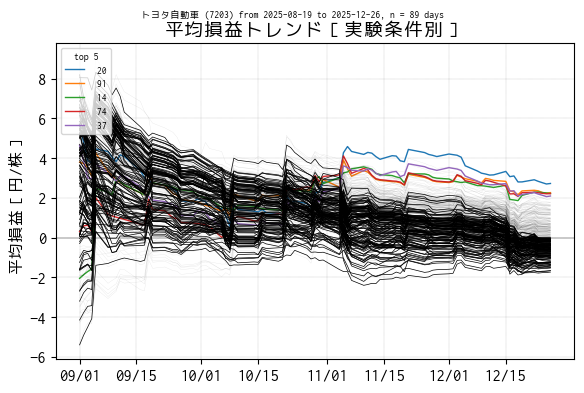

In [36]:
# ---------------------------------------------------------
# 実験条件毎の平均損益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_mean[dt_from <= df_mean.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップランキンgだけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_conditions:  # 最新の平均損益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("平均損益［円/株］")
ax.set_title("平均損益トレンド［実験条件別］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_trend_mean_profit_{target}.png",
)
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## ヒストリカル・データで等高線図 (Contour Map)

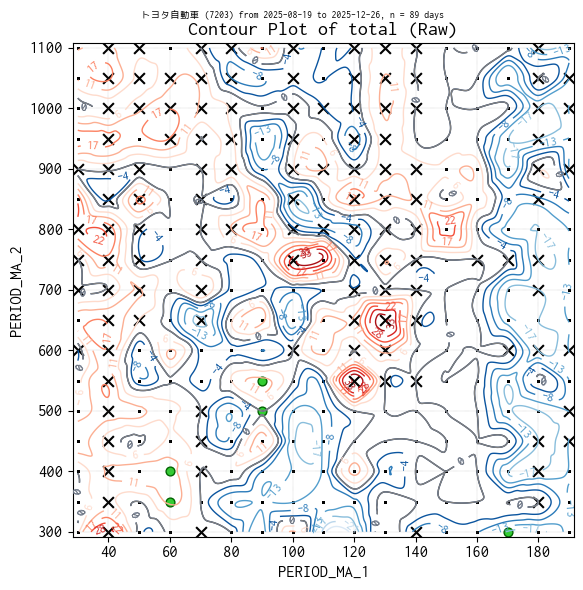

In [37]:
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "total"
x = df[col_x]
y = df[col_y]
z = df[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# 等高線図
plot_contourmap(ax, Xi, Yi, Zi)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title("Contour Plot of total (Raw)")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

# 最適点
ax.scatter(
    df_best[col_x],
    df_best[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)

# 最新の平均収益が負になる点
ax.scatter(
    df_negative[col_x],
    df_negative[col_y],
    marker="x",
    color="black",
    s=60,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

output = os.path.join(
    "..", "output", name_doe, f"{date_str}_{name_code}_raw_contour_{target}.png"
)

plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## （ヒストリカル）メジアン損益の算出

In [38]:
df_median = df_raw.copy()
# データスコープを示す文字列
dt_start = df_median.index[0]
dt_end = df_median.index[-1]
title_scope = f"{dict_code[name_code]} ({name_code}) from {dt_start.date()} to {dt_end.date()}, n = {n_day} days"
print("データスコープを示す文字列")
print(title_scope)

データスコープを示す文字列
トヨタ自動車 (7203) from 2025-08-19 to 2025-12-26, n = 89 days


In [39]:
# メディアン損益の算出
n = len(df_median.index)
while n > 0:
    # 最下行から順にメディアンを算出して、行の内容を置換。
    df_median.iloc[n - 1] = df_median[:n].median()
    n -= 1
print("\ndf_median: 新しい日付から古い日付と逆順にメジアン損益を算出")
print(df_median)

# 最終日の平均収益のランキング
ser_ranking = df_median.iloc[len(df_median) - 1].sort_values(ascending=False)
print("最新のメジアン損益（逆ソート後）")
print(ser_ranking)


df_median: 新しい日付から古い日付と逆順にメジアン損益を算出
             0     1     2     3     4    5      6      7      8      9    \
2025-08-19  3.50  31.5 -2.00  1.50   0.0 -3.5 -15.00 -13.50 -23.00 -21.50   
2025-08-20  6.75  23.0  5.25  7.75   8.5 -2.0  -4.00  -0.75  -6.25  -5.25   
2025-08-21  3.50  14.5 -2.00  1.50   0.0 -3.5 -13.50 -13.50  -8.00 -10.50   
2025-08-22  2.00   8.0 -1.50  4.50   5.5 -6.0  -6.75  -6.50  -4.00  -5.25   
2025-08-25  3.50  10.0 -1.00  7.50  11.0 -3.5   0.00   0.50   0.00   0.00   
...          ...   ...   ...   ...   ...  ...    ...    ...    ...    ...   
2025-12-22  0.00   0.0  0.00  0.00  -1.0  0.0   0.00   0.00   0.00   0.00   
2025-12-23  0.00   0.0  0.00  0.00  -1.0  0.0   0.00   0.00   0.00   0.00   
2025-12-24  0.00   0.0  0.00  0.00  -1.0  0.0   0.00   0.00   0.00   0.00   
2025-12-25  0.00   0.0  0.00  0.00  -1.0  0.0   0.00   0.00   0.00   0.00   
2025-12-26  0.00   0.0  0.00  0.00  -1.0  0.0   0.00   0.00   0.00   0.00   

            ...   279  280   281   282

## サマリ統計（メジアン）

In [40]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["trade", "total"]

# 因子ごとに応答のメディアンを集計（サマリデータ）
df_summary_2 = df.groupby(factor_cols)[response_cols].median().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary_2 = df_summary_2.sort_values(
    ["PERIOD_MA_2", "PERIOD_MA_1"], ignore_index=True
)
print("サマリ統計（メジアン）")
print(df_summary_2)

サマリ統計（メジアン）
     PERIOD_MA_1  PERIOD_MA_2  trade  total
0             30          300    4.0    0.0
1             40          300    4.0    0.0
2             50          300    2.0    0.0
3             60          300    4.0    0.0
4             70          300    4.0   -1.0
..           ...          ...    ...    ...
284          150         1100    0.0    0.0
285          160         1100    0.0    0.0
286          170         1100    0.0    0.0
287          180         1100    0.0    0.0
288          190         1100    2.0    0.0

[289 rows x 4 columns]


### 検算

In [41]:
"""
サマリ統計 (df_summary_2) のメジアン値と、算出したメジアン収益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary_2["total"] - df_median.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## ランキング (2)

In [42]:
# トップランキング
n_top = 10
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary_2.iloc[best_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "メジアン損益"]
df_best.columns = list_col
dt_last = df_raw.index[-1]
ser_best_last = df_raw.loc[dt_last][best_conditions]
df_best[dt_last.date()] = ser_best_last

print("---\n[Best Conditions]")
print(df_best)


# HTML 形式で出力
styled = df_best.style.format({"trade": "{:.1f}", "total": "{:.2f}"}).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)

html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_best_median.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)


# 最新のメジアン収益が負になっている実験条件
negative_conditions = ser_ranking[ser_ranking < 0].index
df_negative = df_summary_2.iloc[negative_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "メジアン損益"]
df_negative.columns = list_col
dt_last = df_raw.index[-1]
ser_negative_last = df_raw.loc[dt_last][negative_conditions]
df_negative[dt_last.date()] = ser_negative_last

print("---\n[Bad Conditions]")
print(df_negative)

---
[Best Conditions]
     PERIOD_MA_1  PERIOD_MA_2  取引回数  メジアン損益  2025-12-26
288          190         1100   2.0     0.0         0.0
272           30         1100   4.0     0.0         0.0
271          190         1050   0.0     0.0         0.0
270          180         1050   0.0     0.0         0.0
269          170         1050   0.0     0.0         0.0
268          160         1050   0.0     0.0         0.0
267          150         1050   0.0     0.0         0.0
266          140         1050   2.0     0.0         0.0
265          130         1050   2.0     0.0         0.0
264          120         1050   2.0     0.0         0.0
---
[Bad Conditions]
     PERIOD_MA_1  PERIOD_MA_2  取引回数  メジアン損益  2025-12-26
276           70         1100   2.0    -0.5         0.0
242           70         1000   4.0    -0.5         0.0
224           60          950   4.0    -0.5         0.0
259           70         1050   2.0    -0.5         0.0
106           70          600   4.0    -0.5         0.0
72   

## 実験条件毎の収益トレンド（メジアン）

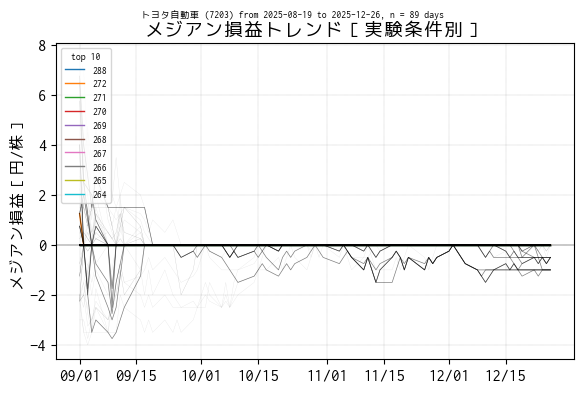

In [43]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_median[dt_from <= df_median.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップランキング だけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_conditions:  # 最新の平均収益が負になっている条件
        ax.plot(
            df_trend[colname],
            linewidth=0.5,
            linestyle="solid",
            color="black",
            alpha=0.5,
        )
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("メジアン損益［円/株］")
ax.set_title("メジアン損益トレンド［実験条件別］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_trend_median_profit_{target}.png",
)
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()